# Data Exploration and first metrics computation
From Laurie Shaw:

Thee first step is simply to get the example script to run (it should produce a bunch of plots, obviously you'll have to adjust the file paths to wherever you saved the tracking data).

Once you've got it to run, try to understand what each line in the example script is doing. 

- The data is mostly stored in 'frames_tb' which is a list of individual frames, as defined by the class with the same name. Each frame instance contains the positions and velocities of the players and ball at a given instant in time. The data is sampled at 25Hz, so there are 25 frames/second, and about 140,000 for the match. 
- The example code gives you some idea of how to extract positions and velocities over some range of frames. 
- The Tracab.py module describes how the data is organized: take a look at the 'tracab_frame' class to see the structure.
- Tracking_Visuals contains plotting routines, and Tracking_Velocities contains the code that calculates player and ball velocities from the positions (which could probably be done better).

In [1]:
import os
import Tracab as tracab
import Tracking_Visuals as vis
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import datetime
import seaborn as sns

import importlib
importlib.reload(tracab)

<module 'Tracab' from '/Users/jeffbalkanski/research_soccer/SoccerTrackingData3/Tracab.py'>

In [8]:
# config
current_dir = os.path.dirname(os.getcwd())
fpath = os.path.join(current_dir, 'TrackingSample') # path to directory of Tracab data
LEAGUE = 'DSL'

match_id = 984628

# Read Tracking data

We read the data:
* frames is a list of the individual match snapshots (positions, velocities)
* match contains some metadata (pitch dimensions, etc)
* team1_players is a dictionary of the home team players (containing arrays of their positions/velocities over the match)
* team0_players is a dictionary of the away team players (containing arrays of their positions/velocities over the match)

In [3]:
# data
fname = '984628'

# read frames, match meta data, and data for individual players
frames_tb, match_tb, team1_players, team0_players = tracab.read_tracab_match_data(LEAGUE, fpath, fname, verbose=True)

Reading match metadata
Reading match tracking data
Timestamping frames
Measuring velocities
home goalkeeper(s):  [1]
away goalkeeper(s):  [73]
0 67615
67616 139808


In [4]:
print('there are {} frames'.format(len(frames_tb)))

there are 139810 frames


### Summaries

In [5]:
summaries_players = pd.read_csv(os.path.join(fpath, '984628_Physical_Summary_1_clean_players.csv'))
summaries_agg = pd.read_csv(os.path.join(fpath, '984628_Physical_Summary_1_clean_agg.csv'), index_col=0)

In [6]:
summaries_agg

,Total,First,Second
Game time,93:13:00,45:05:00,48:08:00
Ball in play,57:51:00,27:12:00,30:39:00
Home TIP,27:23:00,12:36,14:47
Away TIP,29:37:00,13:57,15:40


In [7]:
summaries_players.sort_values(['team_id', 'ID']).head()

,ID,team_id,Player,Minutes,Distance,Standing,Walking,Jogging,Running,High Speed Running,...,Sprint Distance TIP,No. of High Intensity Runs TIP,Distance OTIP,HSR Distance OTIP,Sprint Distance OTIP,No. of High Intensity Runs OTIP,Distance BOP,HSR Distance BOP,Sprint Distance BOP,No. of High Intensity Runs BOP
6,13737,1,Rasmus W�_rtz,93:12:00,11940.46,4.06,3193.13,5601.67,2479.74,583.78,...,22.28,17,5259.72,382.01,55.80,36,2539.78,56.44,0.0,3
11,48597,1,Kasper Risgard,14:44,2039.29,0.00,560.73,736.11,525.74,191.47,...,25.24,10,768.26,53.40,0.00,4,448.40,10.30,0.0,1
4,48601,1,Patrick Kristensen,93:12:00,10907.62,8.13,3216.40,4905.82,2093.52,569.47,...,64.62,25,4381.58,376.43,49.66,33,2546.22,19.84,0.0,4
10,58863,1,Tom van Weert,93:12:00,12351.50,6.16,3393.17,5705.91,2199.89,733.64,...,301.46,58,4746.40,150.89,1.06,17,2864.71,29.00,10.2,7
2,80502,1,Jores Okore,93:12:00,9691.12,7.04,3179.93,4849.27,1262.01,327.06,...,0.00,8,4065.08,266.05,65.81,29,2413.78,6.52,0.0,4


### Splits

* ChyronHego - Tracab Split Data
* Aalborg BK vs AGF Aarhus
* 984628
* Threshold key (km/h)
* Standing : 0.72
* Walking : 7.20
* Jogging : 14.40
* LowSpeedRunning : 19.80
* HighSpeedRunning : 25.20
* LowSpeedSprinting : >25.20

In [8]:
# read
split_players = pd.read_csv(os.path.join(fpath, '984628_Physical_Splits_1_clean_final.csv'),  encoding="ISO-8859-1")

# process
split_players = split_players.set_index(['team', 'player', 'Minute Splits']).reset_index()
clean_names_ids = pd.DataFrame(split_players['player'].map(lambda x: x.rstrip(')')).str.split('(').values.tolist(), 
                                columns=['player_name', 'player_id'])
splits_process_1 = pd.concat([split_players, clean_names_ids], axis=1).set_index(['team', 'player_name', 'player_id'])                                  
splits_process_2 = splits_process_1.drop('player', axis=1)
splits_clean = splits_process_2.reset_index().set_index(['team', 'player_name', 'player_id', 'Minute Splits'])

In [9]:
splits_clean.head()

5       10  \
team             player_name player_id Minute Splits                         
Aalborg BK (401) Aalborg BK  401       Total Distance     7495.37  6339.38   
                                       Standing Distance     6.16     6.05   
                                       Walking Distance   1910.88  1956.86   
                                       Jogging Distance   3520.45   2952.2   
                                       Running Distance   1435.59  1020.35   

                                                               15       20  \
team             player_name player_id Minute Splits                         
Aalborg BK (401) Aalborg BK  401       Total Distance     6762.06  5504.47   
                                       Standing Distance     2.05     5.04   
                                       Walking Distance   1915.04  1888.15   
                                       Jogging Distance   3255.93  2271.40   
                                       Running Distance   1273.04   947.56   

                                                               25       30  \
team             player_name player_id Minute Splits                         
Aalborg BK (401) Aalborg BK  401       Total Distance     5542.31  7196.89   
                                       Standing Distance     7.05     1.05   
                                       Walking Distance   2046.71  1967.71   
                                       Jogging Distance   2407.42  3349.74   
                                       Running Distance    785.70  1259.24   

                                                               35       40  \
team             player_name player_id Minute Splits                         
Aalborg BK (401) Aalborg BK  401       Total Distance     6321.09  5714.89   
                                       Standing Distance     4.05     1.05   
                                       Walking Distance   1998.32  2243.38   
                                       Jogging Distance   2675.88  2542.89   
                                       Running Distance   1090.46   698.71   

                                                               45  \
team             player_name player_id Minute Splits                
Aalborg BK (401) Aalborg BK  401       Total Distance     6024.16   
                                       Standing Distance     4.07   
                                       Walking Distance   2136.17   
                                       Jogging Distance   2507.91   
                                       Running Distance    868.75   

                                                          additional_1  \
team             player_name player_id Minute Splits                     
Aalborg BK (401) Aalborg BK  401       Total Distance            49.03   
                                       Standing Distance          0.00   
                                       Walking Distance          15.43   
                                       Jogging Distance          25.78   
                                       Running Distance           7.82   

                                                               50       55  \
team             player_name player_id Minute Splits                         
Aalborg BK (401) Aalborg BK  401       Total Distance     6937.40  7230.01   
                                       Standing Distance     3.05     2.03   
                                       Walking Distance   2095.69  1965.49   
                                       Jogging Distance   3597.02  3430.36   
                                       Running Distance    982.22  1224.00   

                                                               60       65  \
team             player_name player_id Minute Splits                         
Aalborg BK (401) Aalborg BK  401       Total Distance     5725.23  5723.82   
                                       Standing Distance     5.03     8.07   
              

In [10]:
# get for one player
splits_clean_reset = splits_clean.reset_index()
splits_clean_reset[splits_clean_reset['player_id'] == '155453'].head()

,team,player_name,player_id,Minute Splits,5,10,15,20,25,30,...,50,55,60,65,70,75,80,85,90,additional_2
26,Aalborg BK (401),Kasper Pedersen,155453,Total Distance,629.17,525.22,581.71,455.97,457.43,586.43,...,610.71,565.70,510.56,416.81,475.54,499.75,421.69,493.48,513.26,271.67
27,Aalborg BK (401),Kasper Pedersen,155453,Standing Distance,1.07,0,0.00,1.01,1.01,0.00,...,1.02,0.00,1.00,1.00,0.00,0.00,1.01,0.00,1.02,1.00
28,Aalborg BK (401),Kasper Pedersen,155453,Walking Distance,183.82,160.48,165.30,138.78,173.47,176.34,...,233.51,150.08,193.18,178.91,224.17,215.48,227.48,205.16,230.80,125.42
29,Aalborg BK (401),Kasper Pedersen,155453,Jogging Distance,327.81,282.4,269.80,208.12,250.98,300.72,...,293.70,307.90,193.60,171.02,183.50,172.99,93.89,230.29,261.76,130.54
30,Aalborg BK (401),Kasper Pedersen,155453,Running Distance,98.33,63.93,97.80,57.65,31.97,41.57,...,60.68,68.50,80.92,51.35,62.09,82.49,50.14,58.03,19.68,7.80


In [11]:
# get time series for a player
time_series_182413 = splits_clean_reset[splits_clean_reset['player_id'] == str(182413)] \
                            .drop(['team', 'player_name', 'player_id'], axis=1).T \
                            .reset_index()

time_series_182413.head()              

,index,13,14,15,16,17,18,19,20,21,22,23,24,25
0,Minute Splits,Total Distance,Standing Distance,Walking Distance,Jogging Distance,Running Distance,High Speed Running Distance,Sprinting Distance,Standing Count,Walking Count,Jogging Count,Running Count,High Speed Running Count,Sprinting Count
1,5,281.77,2.02,201.51,52.75,17.66,7.83,0,12,18,6,1,1,0
2,10,235.54,2.02,174.1,59.42,0,0,0,6,12,8,0,0,0
3,15,296.18,1.04,218.2,69.46,7.48,0,0,5,12,5,2,0,0
4,20,229.44,1.03,149.39,79.02,0,0,0,13,20,12,0,0,0


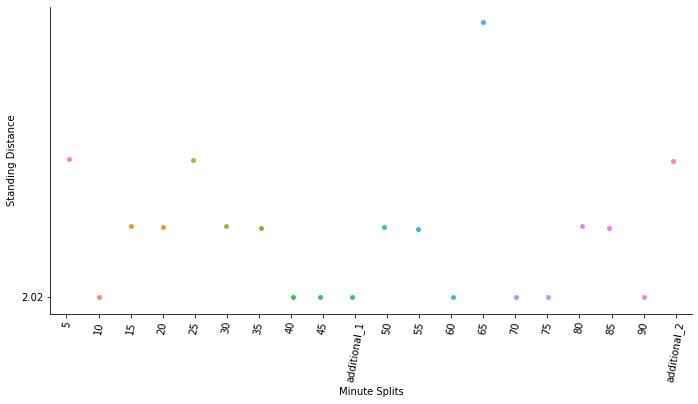

In [12]:
toplot = time_series_182413.rename(columns=time_series_182413.iloc[0]).drop(0)
# fig, ax = plt.subplots(figsize=(10, 5))
sns.catplot(data=toplot, x='Minute Splits', y='Standing Distance', height=5, aspect=2)

plt.xticks(rotation=80)

plt.show()

In [13]:
# sum to get summary
splits_clean['summary'] = splits_clean.sum(axis=1)

# reproduce summary
summary_from_split = splits_clean['summary'].unstack().reset_index()

# cast
summary_from_split = summary_from_split.astype({'player_id':int})

In [14]:
summary_from_split.sort_values(['team', 'player_id']).head()

Minute Splits,team,player_name,player_id,High Speed Running Count,High Speed Running Distance,Jogging Count,Jogging Distance,Running Count,Running Distance,Sprinting Count,Sprinting Distance,Standing Count,Standing Distance,Total Distance,Walking Count,Walking Distance
0,AGF Aarhus (420),AGF Aarhus,420,493.0,6630.52,3732.0,44206.67,1500.0,16935.87,88.0,1698.15,531.0,70.23,106031.85,3564.0,36490.41
7,AGF Aarhus (420),Jesper Juelsgaard,48715,42.0,523.25,350.0,3423.31,133.0,1316.08,11.0,243.69,67.0,8.08,9501.84,369.0,3987.43
13,AGF Aarhus (420),Tobias Sana,61778,54.0,688.53,362.0,3900.30,162.0,2114.58,11.0,199.76,53.0,5.13,10509.51,348.0,3601.21
12,AGF Aarhus (420),Patrick Mortensen,85050,46.0,625.07,363.0,3985.75,166.0,1823.67,4.0,49.45,41.0,7.07,10002.84,340.0,3511.83
6,AGF Aarhus (420),Jakob Ankersen,89226,47.0,709.24,276.0,4210.30,118.0,1452.96,6.0,180.66,30.0,8.12,8792.01,245.0,2230.73


### Player_id to name mapping

In [15]:
player_id_to_name = splits_clean.reset_index()[['player_name', 'player_id']].drop_duplicates().set_index('player_id').to_dict()['player_name']

### Player_id to jersey_num mapping

`G: Goalkeeper
RFB: Right full back
CD: Central defender
CDM: Central defensive midfielder
RM: Right midfielder
RW: Right wing
RWB: Right wing back
AM: Attacking midfielder
FW: Forward`

In [3]:
player_id_to_name = pd.read_csv(os.path.join(fpath, 'playerid_jerseynum_map.csv'))

In [12]:
player_id_to_name[player_id_to_name['Match ID'] == match_id]

,Match ID,Team,Playerid,Player name,Jersey Num,Starting Position,Starts Match
6005,984628,Home,182413,Jacob Rinne,1,GK,Start
6006,984628,Home,48601,Patrick Kristensen,2,RFB,Start
6007,984628,Home,180169,Philipp Ochs,11,LFB,Start
6008,984628,Home,80502,Jores Okore,5,CD,Start
6009,984628,Home,155453,Kasper Pedersen,32,CD,Start
6010,984628,Home,84500,Kasper Kusk,17,RM,Start
6011,984628,Home,192161,Frederik Borsting,25,LM,Start
6012,984628,Home,13737,Rasmus Wurtz,8,CM,Start
6013,984628,Home,213602,Oliver Abildgaard,7,CM,Start
6014,984628,Home,58863,Tom van Weert,9,FW,Start


---
# Read Type IDs

In [21]:
QualID_Descriptions = pd.read_csv('QualID_Descriptions.csv', index_col=0)
# QualID_Descriptions.head()

In [22]:
TypeID_Descriptions = pd.read_csv('TypeID_Descriptions.csv', index_col=0)
# TypeID_Descriptions

---

# Parsing the code
Here is how the raw code is read

In [23]:
# config
verbose = True

In [24]:
fmetadata, fdata = tracab.get_tracabdata_paths(fpath, fname, league=LEAGUE)
print(fmetadata, fdata)

/Users/jeffbalkanski/research_soccer/TrackingSample/984628_metadata.xml /Users/jeffbalkanski/research_soccer/TrackingSample/984628.dat


In [25]:
match = tracab.read_tracab_match(fmetadata)

In [26]:
display(match.match_attributes)
print()
display(match.period_attributes)

{'iId': '984628',
 'dtDate': '2019-03-17 17:00:00',
 'iFrameRateFps': '25',
 'fPitchXSizeMeters': '105.00',
 'fPitchYSizeMeters': '68.00',
 'fTrackingAreaXSizeMeters': '111.00',
 'fTrackingAreaYSizeMeters': '88.00'}

{1: {'iId': 1, 'iStartFrame': 1536511, 'iEndFrame': 1604126},
 2: {'iId': 2, 'iStartFrame': 1627533, 'iEndFrame': 1699726}}

In [27]:
# read in tracking data
if verbose:
    print("Reading match tracking data")
frames = []
with open(fdata, "r") as fp:
    # go through line by line and break down data in individual players and the ball
    for f in fp:             
        # each line is a single frame
        chunks = f.split(':')[:-1] # last element is carriage return \n
        if len(chunks) > 3:
            print(chunks)
            raise Exception('More than 3 chunks in line of data: %s', chunks)

        frameid = int(chunks[0])
        frame = tracab.tracab_frame(frameid)  

        # Get players
        targets = chunks[1].split(';')
        assert(targets[-1] == '')
        for target in targets[:-1]:
            target = target.split(',')
            team = int(target[0])
            if team in [1, 0, 3]:
                frame.add_frame_target(target)

        # Is this never the case?
        if len(chunks) > 2:
            frame.add_frame_ball(chunks[2].split(';')[0].split(','))
        frames.append(frame)
        
        # testing
        break
            

Reading match tracking data


## Chunk description
#### Chunk 2
` targets assigned team*, system target ID, assigned jersey** number, pitch position x***, pitch position y***, target speed****`

-   \* Valid values: 1=Hometeam, 0=Awayteam, 3=Referee. Other values are used for internal purposes. 
- \** Jersey numbers are 1-99. Jersey -1 is unassigned except for team 3 (the referee).
- \*** Positions in centimeters according to the Tracab coordinate system.
- \**** Speed in meters per second.

#### Chunk 3
`pitch position x*, pitch position y*, pitch
position z*, ball speed**, ball owning team***, ball status****, (not always set) ball
contact device info 1 *****, (not always set) ball contact device info 2 *****`

- \* Positions in centimeters according to the Tracab coordinate system. Note that the position of the ball center is displayed. Normal z position for a ball on ground is thereby 10 cm.
- \** Speed in meters per second.
- \*** "H" (home) or "A" (away). Optional.
- \**** "Alive" or "Dead". Optional.
- \****  Two properties describing if buttons are pressed on the ball contact log device. The device has four buttons and the two button properties describe their status. Various combinations can be expected. Optional.

In [28]:
# chunks of data area read
print('ONE FRAME: \n')
print(chunks[0], '\n')

for x in chunks[1].split(';'):
    print(x)
    break
print('\n', chunks[2])

ONE FRAME: 

1505174 

-1,1,-1,4257,-146,0.00

 -3892,-1852,4,37.34,A,Dead;


---


# Reproducing split metrics 

read frames, match meta data, and data for individual players

> frames_tb, match_tb, team1_players, team0_players

In [29]:
import pandas as pd
import helpers

importlib.reload(helpers)

<module 'helpers' from '/Users/jeffbalkanski/research_soccer/SoccerTrackingData3/helpers.py'>

In [30]:
# example 
split_size = 5
player = team0_players[5]

## Minutes on the field

In [31]:
# find number of minutes on the field
player = team1_players[11]


In [32]:
# get total time
helpers.get_total_time(player)

93.20533333333333

In [33]:
print('first and last frame id: ', player.frameids[1], player.frameids[-1])
print('Period: ', frames_tb[0].period)

first and last frame id:  1536512 1699726
Period:  1


In [34]:
# find total time for all players
for n, p in team0_players.items():
    print(helpers.get_total_time(p))
    break
# ????

93.20533333333333


# Get total distance
> helpers.get_total_distance

In [35]:
# test
player = team1_players[11]

# test apply_by_split
result_one_player = helpers.apply_by_split(player, helpers.get_total_distance, metric_name='metric')

# get all data 
distances = helpers.apply_to_all(team1_players, team0_players, 
                                 helpers.get_total_distance, metric_name='distance')

In [36]:
# summary
distances['total'].reset_index().T

,0,1,2,3,4,5,6,7,8,9,...,16,17,18,19,20,21,22,23,24,25
team_id,0,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,1
jersey_num,35,5,7,8,73,11,13,16,17,18,...,5,7,8,9,10,11,17,18,21,25
total,8448.92,10559.49,9830.21,11152.22,6970.03,11610.56,12021.0,11324.36,3986.99,10665.82,...,10260.91,12461.74,12455.06,12807.76,11595.37,10988.25,9427.29,2574.43,2140.89,10382.08


In [37]:
# splits
distances.head()

0                        5      10      15      20      25      30      35  \
team_id jersey_num                                                           
0       35          729.96  686.71  659.32  554.43  557.01  771.57  674.09   
        5            684.7  579.77  542.79  508.58  511.82  649.42  630.42   
        7           747.56  705.56  673.11  546.68   629.3  760.05  686.63   
        8            786.7   641.0  626.33  588.99  525.34  673.86   636.6   
        73          418.77  432.14  415.41  364.71  389.19   409.0  319.16   

0                       40      45 additional_1  ...      55      60      65  \
team_id jersey_num                               ...                           
0       35           544.8   675.0         8.81  ...  737.88  546.74  476.23   
        5           443.19  586.64         12.4  ...  612.65  480.56  555.21   
        7           619.97  747.42        10.29  ...  763.98  536.86  640.26   
        8           459.13  562.89         9.32  ...  698.27  443.84  598.98   
        73          315.81  365.64         6.97  ...  386.22  297.99  373.03   

0                       70      75      80      85      90 additional_2  \
team_id jersey_num                                                        
0       35             0.0     0.0     0.0     0.0     0.0          0.0   
        5           573.94  489.55   422.5  581.72  696.25       371.75   
        7           661.68  371.67     0.0     0.0     0.0          0.0   
        8            573.3  611.77  442.56  619.38   610.2       349.68   
        73          359.94  298.27  250.41  371.06  388.28       319.56   

0                      total  
team_id jersey_num            
0       35           8448.92  
        5           10559.49  
        7            9830.21  
        8           11152.22  
        73           6970.03  

[5 rows x 21 columns]

In [38]:
distances = distances.astype(float)

### visualize

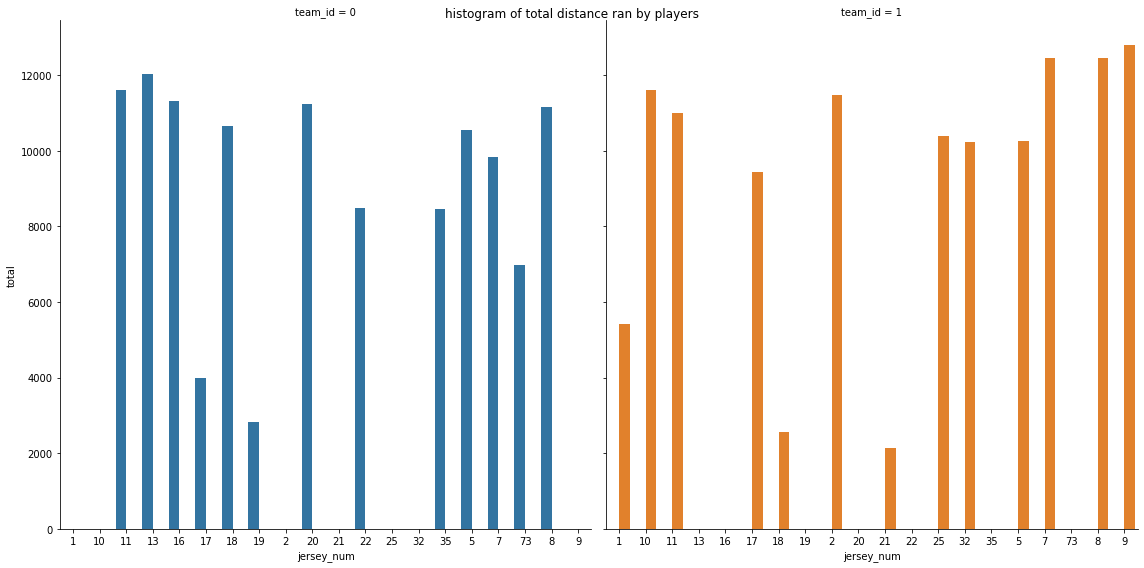

In [39]:
# plot 
sns.catplot(data=distances[['total']].reset_index(), 
            kind='bar',
            x='jersey_num', y='total', col='team_id', hue='team_id',
           height=8, aspect=1)

plt.suptitle('histogram of total distance ran by players')

plt.show()

[]

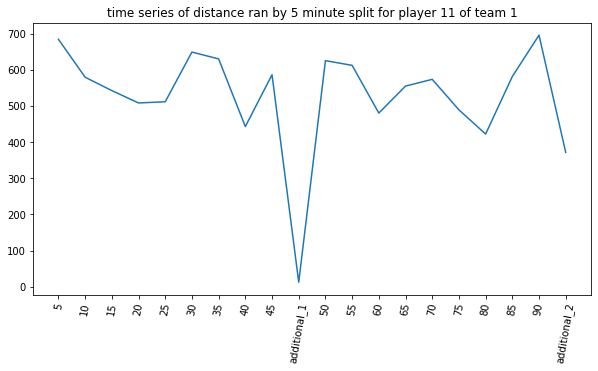

In [40]:
# plot
fig, ax = plt.subplots(figsize=(10, 5))
sns.lineplot(data=distances.loc['0', '5'].drop('total'), sort=False, ax=ax)

plt.xticks(rotation=80)
plt.title('time series of distance ran by 5 minute split for player {} of team {}'.format(player.jersey_num, player.teamID))

plt.plot()

In [41]:
# two methods:
print(helpers.get_total_distance(player))
print(helpers.apply_by_split(player, helpers.get_total_distance)[1][-1])

10989.73
10988.25


In [42]:
player.jersey_num

11

# Speed
We must **verify** the precision of the speed given by the `.dat` file
> look at `Tracking_velocities.estimate_ball_velocities` in the tracab tracking velocities code code 

A frame is the following:
> from the data: 'jersey_num','pos_x', 'pos_y', 'speed','sys_target_ID', team

> from computation:  'speed_filter',  'vx', 'vy'

In [43]:
player05 =  team0_players[5]

In [44]:
player05.frame_targets[3].sys_target_ID

15

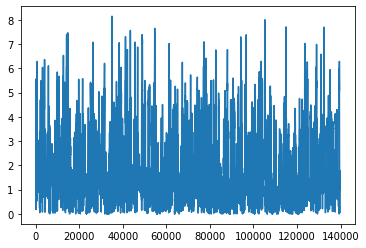

In [45]:
# get velocities for one player
vs = helpers.get_all_values(player05, 'speed_filter')

plt.plot(vs)

### Top Speed split

In [46]:
# time series top speed
top_speed_m_s = helpers.apply_to_all(team1_players, team0_players, helpers.top_speed)\
                            .drop('total', axis=1) \
                            .astype(float)

top_speed_m_s_data = helpers.apply_to_all(team1_players, team0_players, helpers.top_speed, source='data')\
                            .drop('total', axis=1) \
                            .astype(float)

# km/h
top_speed_km_h = helpers.apply_to_all(team1_players, team0_players, helpers.top_speed, unit='kmh').astype(float)

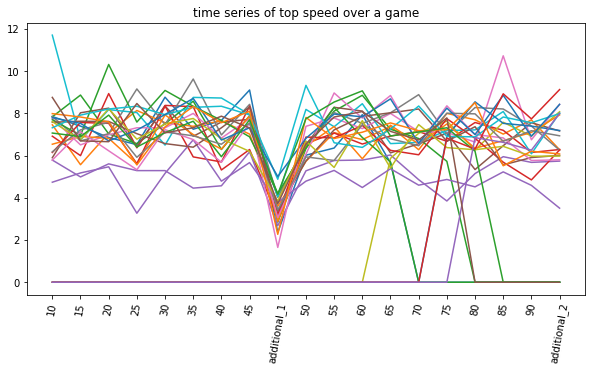

In [47]:
# plot time series
fig, ax = plt.subplots(figsize=(10, 5))
idx = top_speed_m_s.columns
for series in top_speed_m_s.values:
    ax.plot(idx, series)
    
plt.xticks(rotation=80)
plt.title('time series of top speed over a game')
    
plt.show()

 we compare the  velocity computer with the velocity given by the data

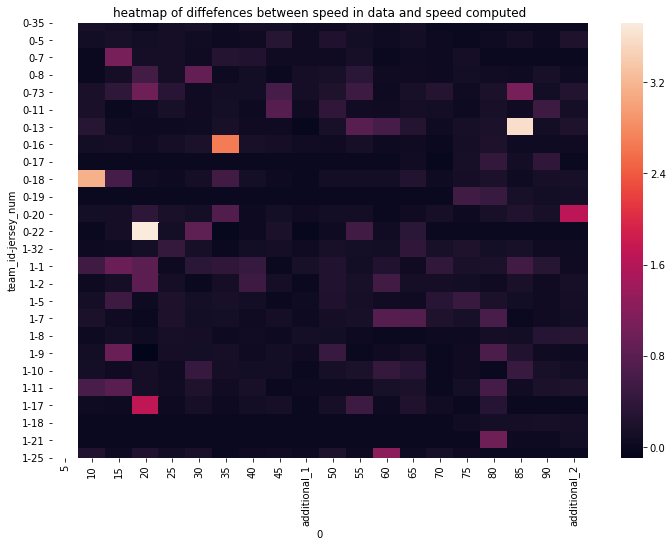

In [48]:
# plot differences
fig, ax = plt.subplots(figsize=(12, 8))
sns.heatmap(top_speed_m_s - top_speed_m_s_data, ax=ax)
plt.title('heatmap of diffefences between speed in data and speed computed')
plt.show()

### Mean speed splits

In [49]:
# time series top speed
mean_speed_m_s = helpers.apply_to_all(team1_players, team0_players, helpers.mean_speed)\
                            .drop('total', axis=1) \
                            .astype(float)

# km/h
mean_speed_km_h = helpers.apply_to_all(team1_players, team0_players, helpers.mean_speed, unit='kmh').astype(float)

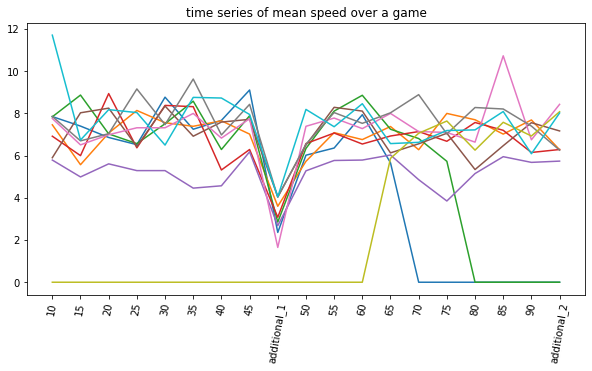

In [50]:
# plot time series
fig, ax = plt.subplots(figsize=(10, 5))

idx = mean_speed_m_s.columns
for series in mean_speed_m_s.values[:10]:
    ax.plot(idx, series)
    
plt.xticks(rotation=80)
plt.title('time series of mean speed over a game')
plt.show()

In [51]:
top_speed_m_s = helpers.apply_to_all(team1_players, team0_players, helpers.top_speed)\
                            .drop('total', axis=1) \
                            .astype(float)

# Acceleration

In [52]:
all_players = [x for x in team0_players.items()] + [x for x in team1_players.items()]

for (num, player) in all_players: 
    print(player.frame_targets[4])
    break

In [53]:
vs = helpers.get_all_values(player05, 'accelerations')


AttributeError: 'tracab_target' object has no attribute 'accelerations'

In [ ]:
plt

In [ ]:
accelerations =[]
for i in range(len(player.frame_targets) - 1):    

    vt0x, vt0y = player.frame_targets[i].vx, player.frame_targets[i].vy
    vt1x, vt1y = player.frame_targets[i+1].vx, player.frame_targets[i+1].vy

    acc_x = (vt1x - vt0x)
    acc_y = (vt1y - vt0y)

    acc = (acc_x, acc_y)
    
    accelerations.append(acc)


In [ ]:
all_players = [x for x in team0_players.items()] + [x for x in team1_players.items()]
for (num, player) in all_players:
    accelerations = []
    for i in range(len(player.frame_targets ) - 1):    
        vt0x, vt0y = player.frame_targets[i].vx, player.frame_targets[i].vy
        vt1x, vt1y = player.frame_targets[i+1].vx, player.frame_targets[i+1].vy

        acc_x = (vt1x - vt0x)
        acc_y = (vt1y - vt0y)
        acc = (acc_x, acc_y)
        
        frame = player.frame_targets[i]

        frame.accelerations = acc
        
        
        


In [ ]:
player.frame_targets[10000].accelerations